In this file the ARIMA is used to analyse time series of

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import libpysal as ps
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [4]:
# load data
df_chicago = pd.read_csv('Crime/Crimes_-_2001_to_Present.csv', index_col='ID')
# clean the data without geocode and time stamp
df_chicago = df_chicago.dropna(subset=['Date', 'Location'])
df_chicago['Date'] = pd.to_datetime(df_chicago['Date'])
# correct the value of crime type
df_chicago['Primary Type'].replace('CRIM SEXUAL ASSAULT', 'CRIMINAL SEXUAL ASSAULT', inplace=True)


Conduct temporal analysis


In [5]:
# get the temporal series of crime data
crime_temp=df_chicago.groupby(pd.Grouper(key='Date',freq='M')).size()

In [57]:
# conduct Augmented Dickey-Fuller Test
# If the ADF statistics has low p-value and close confidence interval, the time-series will be considered as stationary
from statsmodels.tsa.stattools import adfuller
res=adfuller(crime_temp.values)
print(f'ADF Statistics:{res[0]}')
print(f'p-value:{res[1]}')
print(f'Critical values')
for k,v in res[4].items():
    print(f'\t{k}: {v}')


ADF Statistics:0.32882288620961675
p-value:0.9786288989149134
Critical values
	1%: -3.4594900381360034
	5%: -2.8743581895178485
	10%: -2.573601605503697


The time series is not stationary

AttributeError: 'list' object has no attribute 'title'

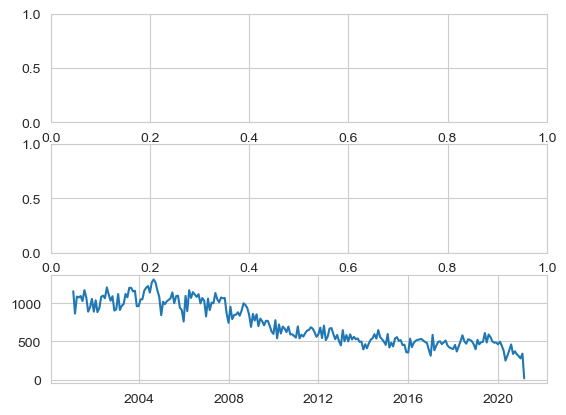

In [64]:

fig,ax=plt.subplots(3,1)

plt.plot(crime_temp.index,crime_temp.values)
ax.title('Number of crime cases against women and children per month')
ax.xlabel('Date')
ax.ylabel('Number of Crimes per month')

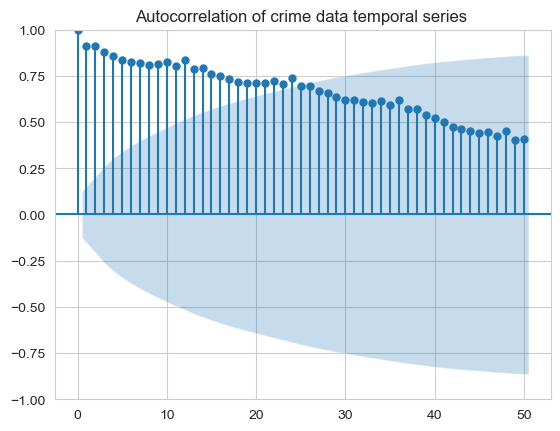

In [67]:
# ACF is used to determine the MA order
ax2=plot_acf(crime_temp.values,title='Autocorrelation of crime data temporal series ',lags=50)

C:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


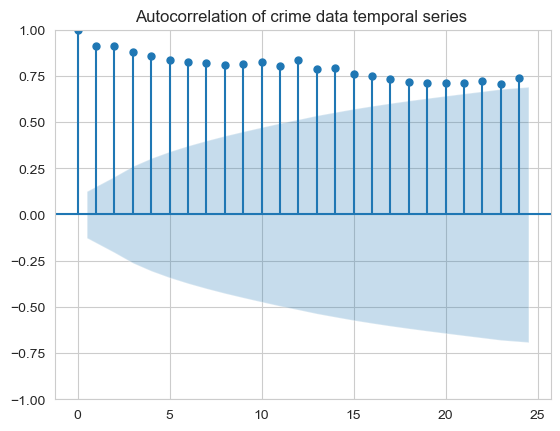

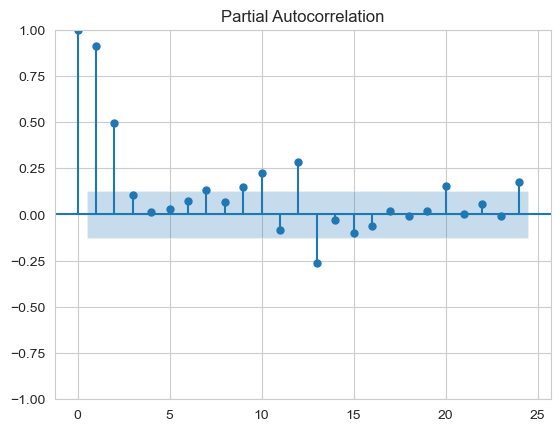

In [27]:
# the number of significant lags indicates $q$ for AR order
ax3=plot_pacf(crime_temp.values)

# Differencing the time series to make it stationary

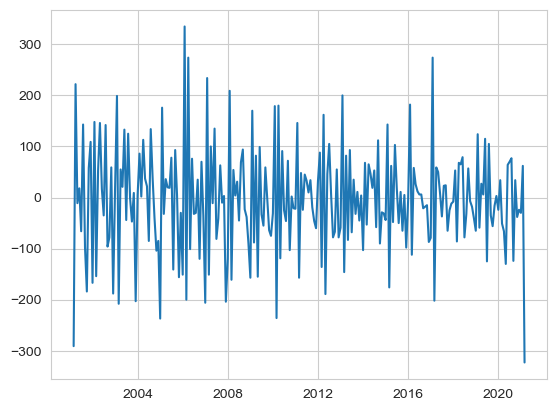

In [68]:
# Take the first order difference to remove the linear trend
plt.plot(crime_temp.diff(periods=1))

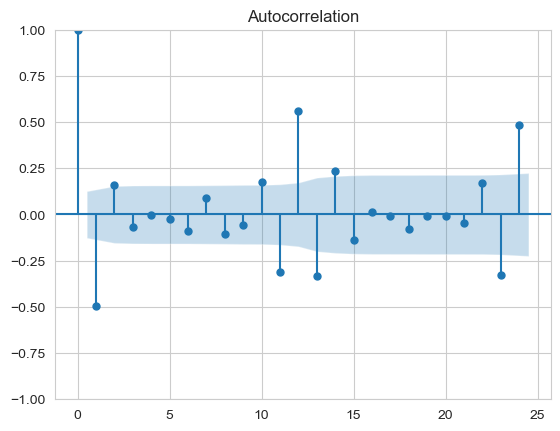

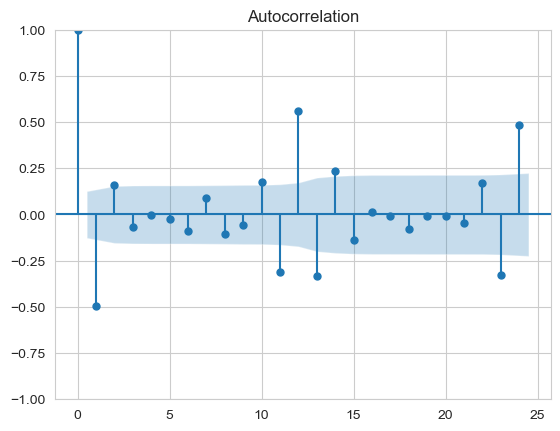

In [42]:
# detrend the data
plot_acf(crime_temp.diff(periods=1)[1:])


In [60]:
## examine the first order differencing of time series
crime_temp_diff1=crime_temp.diff(periods=1)[1:]
res=adfuller(crime_temp_diff1.values)
print(f'ADF Statistics:{res[0]}')
print(f'p-value:{res[1]}')
print(f'Critical values')
for k,v in res[4].items():
    print(f'\t{k}: {v}')

ADF Statistics:-3.4924576658890603
p-value:0.008182923210085097
Critical values
	1%: -3.4594900381360034
	5%: -2.8743581895178485
	10%: -2.573601605503697


The ACF of differenced time series shows high value at fixed intervals, showing that seasonal autoregressive term is included.

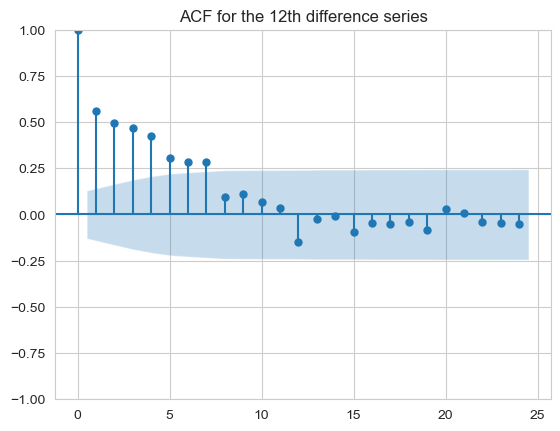

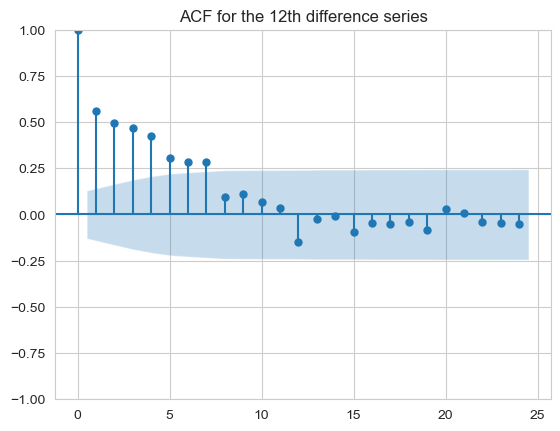

In [72]:
# remove the seasonality
crime_temp_diff12=crime_temp.diff(periods=12)[12:]
plot_acf(crime_temp_diff12,title='ACF for the 12th difference series')
#the ACF is exponentially decaying to zero, use AR model

C:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


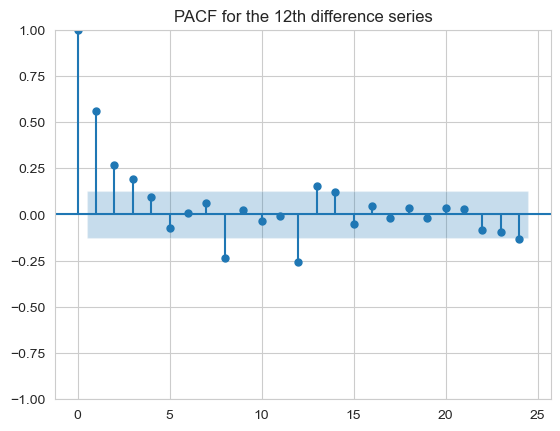

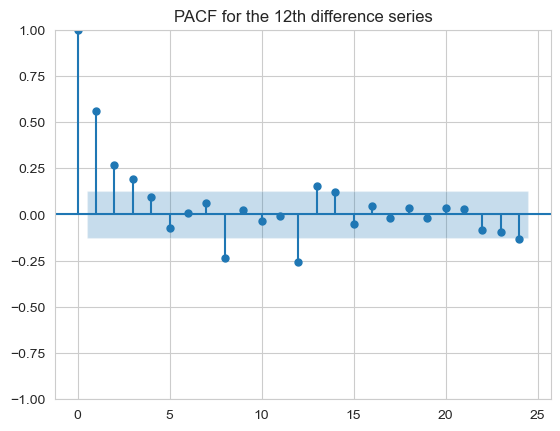

In [71]:
plot_pacf(crime_temp_diff12,title='PACF for the 12th difference series')

In [59]:
# examine the time series
diff=crime_temp.diff(periods=1)[1:]
res=adfuller(diff.values)
print(f'ADF Statistics:{res[0]}')
print(f'p-value:{res[1]}')
print(f'Critical values')
for k,v in res[4].items():
    print(f'\t{k}: {v}')


ADF Statistics:-3.4924576658890603
p-value:0.008182923210085097
Critical values
	1%: -3.4594900381360034
	5%: -2.8743581895178485
	10%: -2.573601605503697


The ACF decays after a few lags, indicating a mixed AR and MA model. The time span is 12 months, meaning that $S=12$

# Steps of ARIMA
## model parameter
$ ARIMA (p,d,q)* (P,D,Q)S $

PACF-> AR->p,P
ACF-> MA -> q,Q
p = non-seasonal AR order,
d = non-seasonal differencing,
q = non-seasonal MA order,
P = seasonal AR order,
D = seasonal differencing,
Q = seasonal MA order,

S = time span of repeating seasonal pattern.


(Box-Jenkins approach)
1. Exploratory
2. Autocorrelation and PACF (partial autocorrelation analysis)--> examing the general characteristics of series and differencing it to make it *stationary*
3. Model identification: use ACF and PACF plots to determine $(p,q,d)$ values
4. Parameter estimation and fitting: use the $p,q,d$ to fit the model
5. Diagnostic checking:check autocorrelation residual, if confirmed to be uncorrelated
6. Forcasting

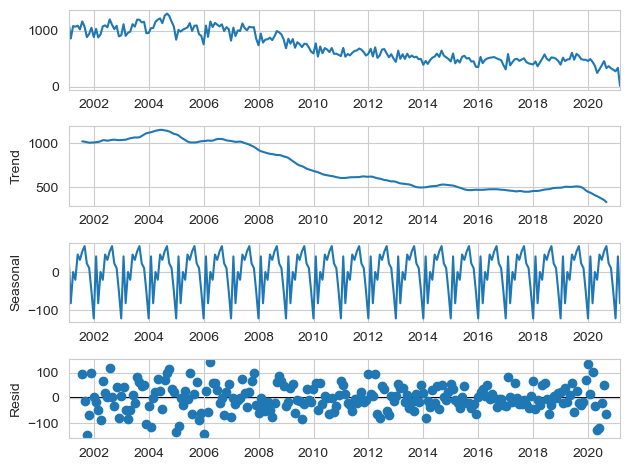

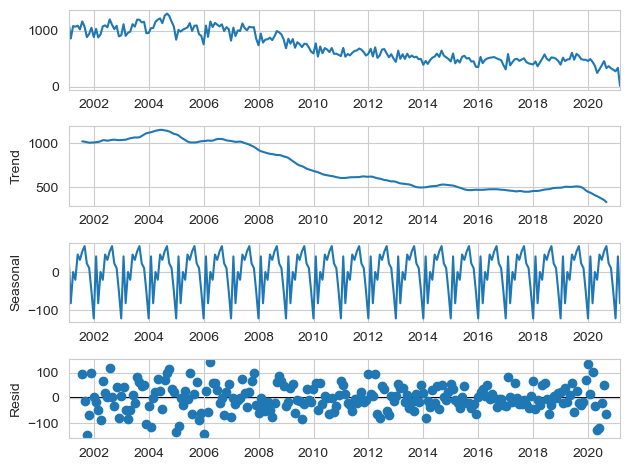

In [61]:
# check whether seasonal pattern exists
from statsmodels.tsa.seasonal import seasonal_decompose
#
from statsmodels.tsa.arima_model import ARIMA

crime_decomposition=seasonal_decompose(crime_temp)
crime_decomposition.plot()

In [10]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(crime_temp, start_p = 1, start_q = 1,
                          max_p = 4, max_q = 4, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=2596.683, Time=1.06 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2767.670, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2651.426, Time=0.37 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2696.108, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2796.416, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=2653.469, Time=0.32 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=3.86 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=2627.013, Time=0.83 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=2598.913, Time=5.30 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=2626.552, Time=0.57 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=2597.334, Time=1.53 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=2597.291, Time=1.58 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=2762.558, Time=0.29 sec
 ARIMA(0,0,2)(0,1,1)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  242
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1293.342
Date:                            Sun, 12 Mar 2023   AIC                           2596.683
Time:                                    22:05:06   BIC                           2613.874
Sample:                                01-31-2001   HQIC                          2603.618
                                     - 02-28-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.7639      0.974     -1.811      0.070      -3.673       0.145
ar.L1          0.9572      0.024     39.301      0.000       0.909       1.005
ma.L1         -0.5477      0.060     -9.070      0.000      -0.666      -0.429
ma.S.L12      -0.7907      0.061    -12.945      0.000      -0.910      -0.671
sigma2      4239.1109    352.436     12.028      0.000    3548.349    4929.872
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                16.61
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.38
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
from statsmodels.tsa.statespace.sarimax import  SARIMAX
model=SARIMAX(crime_temp.values
            ,order=(1,0,1),seasonal_order=(0,1,1,12))
result= model.fit(disp=-1)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  242
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1295.765
Date:                            Tue, 14 Mar 2023   AIC                           2599.530
Time:                                    12:21:10   BIC                           2613.282
Sample:                                         0   HQIC                          2605.077
                                            - 242                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9896      0.013     77.860      0.000       0.965       1.015
ma.L1         -0.5757      0.054    -10.623      0.000      -0.682      -0.469
ma.S.L12      -0.7782      0.061    -12.807      0.000      -0.897      -0.659
sigma2      4330.5076    340.105     12.733      0.000    3663.914    4997.101
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                21.15
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.47
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

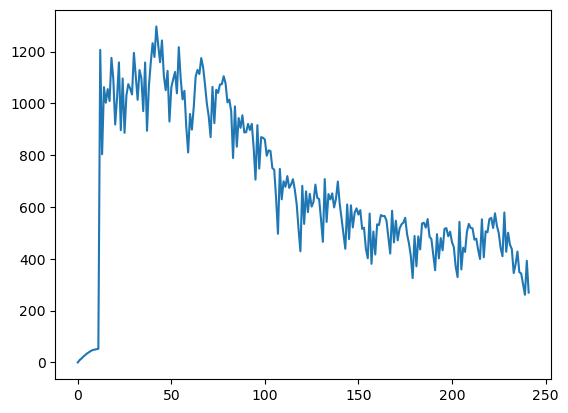

In [43]:
plt.plot(result.fittedvalues)

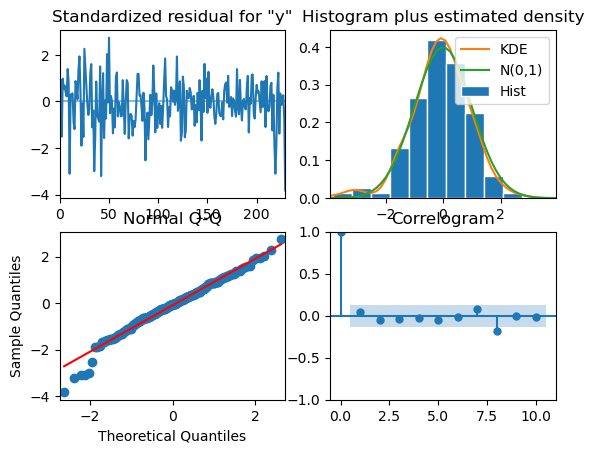

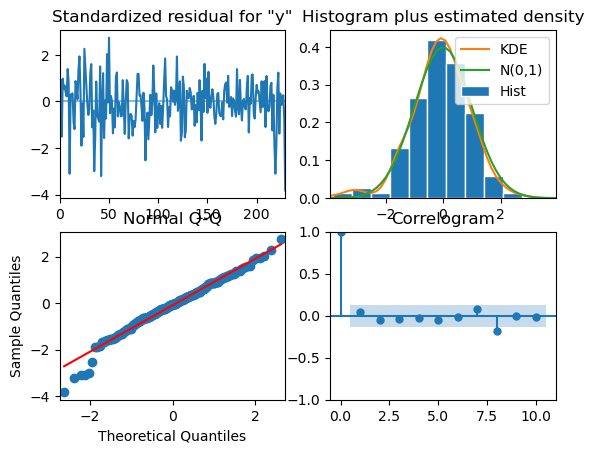

In [44]:
result.plot_diagnostics()

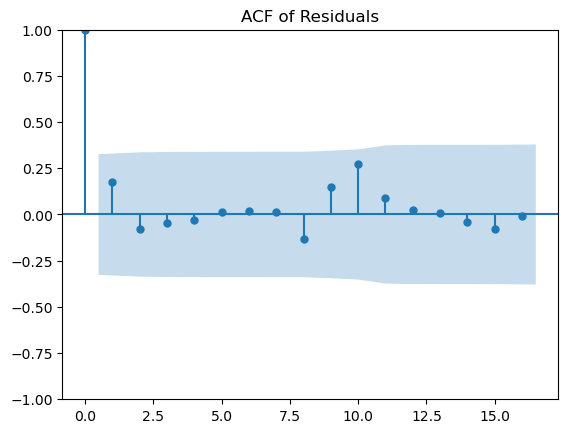

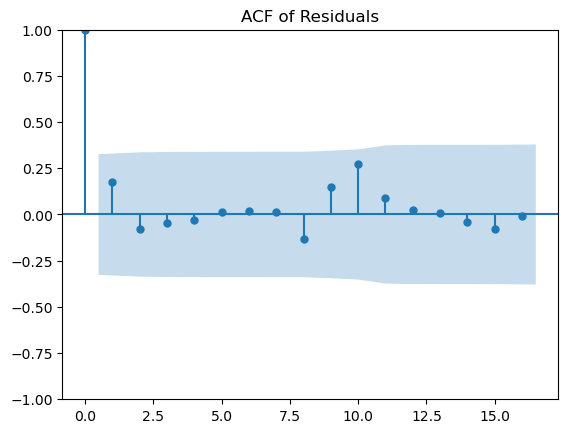

In [22]:
# make prediction

crime_train=crime_temp.iloc[:len(crime_temp)-36]
crime_test=crime_temp.iloc[len(crime_temp)-36:]
start = len(crime_train)
end = len(crime_train) + len(crime_test) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels')

# examine the residual
residual=predictions-crime_test
plot_acf(residual,title="ACF of Residuals")


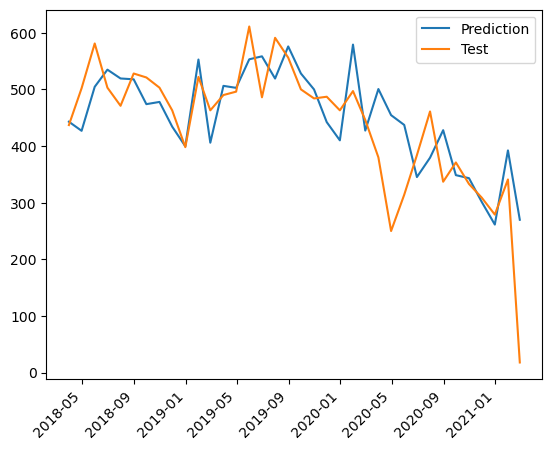

In [31]:
# make prediction
# plot predictions and actual values
time=crime_test.index
fig,ax=plt.subplots()
ax.plot(time,predictions,label='Prediction')
ax.plot(time,crime_test.values,label='Test')
plt.xticks(rotation=45, ha='right') # rotate x-ticks for readability
plt.legend()

In [33]:
# calculate accuracy

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
print(f'RMSE:{rmse(crime_test, predictions)}')

# Calculate mean squared error
print(f'MSE:{mean_squared_error(crime_test, predictions)}')

RMSE:75.50802701768036
MSE:5701.4621441027475


In [37]:

crime_temp.index[-1]

Timestamp('2021-02-28 00:00:00', freq='M')

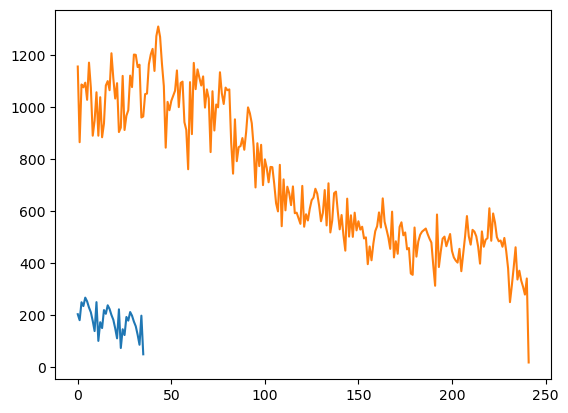

In [36]:
# forcast for the next 3 years
# Forecast for the next 3 years
import datetime
forecast = result.predict(start = len(crime_temp),
                          end = (len(crime_temp)-1) + 3 * 12,
                          typ = 'levels')
forecast_time=[datetime.datetime()]
# Plot the forecast values
fig,ax=plt.subplots()


ax.plot(crime_temp.index,crime_temp.values,label='Test')
ax.plot(forecast,label='Forcast')


In [41]:
forecast_series=pd.Series(data=forecast,index=pd.DatetimeIndex)

C:\Users\skyla\AppData\Local\Temp\ipykernel_32164\2912661494.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat(crime_temp.values,forecast)


TypeError: cannot concatenate object of type '<class 'numpy.int64'>'; only Series and DataFrame objs are valid